<a href="https://colab.research.google.com/github/Xavier26King/ML-Prerequisite-Test/blob/main/stable_diffusion_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers accelerate datasets pillow matplotlib numpy tqdm
!pip install diffusers[training] xformers

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (780.5 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_curand_cu1

^C


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTextModel, CLIPTokenizer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from tqdm import tqdm
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. CONFIGURATION AND HYPERPARAMETERS

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    # Model architecture
    image_size: int = 512
    latent_dim: int = 256
    in_channels: int = 3

    # Training
    batch_size: int = 10
    learning_rate: float = 1e-4
    num_epochs: int = 50

    # Text conditioning
    text_embed_dim: int = 768
    condition_dim: int = 1024

    # Paths (CSV-based Flickr8k format)
    dataset_root: str = "/kaggle/input/flickr8k"  # or "/content/drive/..." if on Google Drive
    image_folder: str = "/kaggle/input/flickr8k/Images"  # update as needed
    captions_csv: str = "/kaggle/input/flickr8k/captions.txt"

    # Output
    output_model_path: str = "/content/drive/MyDrive/T2I_Project/DATASET/model_12_257.pt"


## 2. UTILITY FUNCTIONS

In [ ]:
def make_beta_schedule(schedule_type="linear", num_timesteps=1000, start=1e-4, end=2e-2):
    """Create noise schedule"""
    if schedule_type == "linear":
        betas = torch.linspace(start, end, num_timesteps)
    elif schedule_type == "cosine":
        steps = num_timesteps + 1
        x = torch.linspace(0, num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / num_timesteps) + 0.008) / 1.008 * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = torch.clamp(betas, 0.0001, 0.9999)
    return betas

def extract(a, t, x_shape):
    """Extract coefficients at specified timesteps"""
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



## 3. ATTENTION MECHANISMS



In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = context_dim or query_dim

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = context if context is not None else x
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: t.view(*t.shape[:2], h, -1).transpose(1, 2), (q, k, v))

        sim = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = mask.reshape(mask.shape[0], 1, 1, mask.shape[1])
            sim = sim.masked_fill(~mask, float('-inf'))

        attn = F.softmax(sim, dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = out.transpose(1, 2).reshape(*out.shape[:2], -1)

        return self.to_out(out)


class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=8):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = nn.GroupNorm(32, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x_norm = self.norm(x)
        qkv = self.qkv(x_norm)
        qkv = qkv.view(b, 3, self.num_heads, c // self.num_heads, h * w)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) * (c // self.num_heads) ** -0.5
        attn = F.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.view(b, c, h, w)
        out = self.proj_out(out)

        return x + out

## 4. UNET BUILDING BLOCKS

In [ ]:
class TimestepEmbedding(nn.Module):
    def __init__(self, channels, time_embed_dim):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

    def forward(self, t):
        return self.time_embed(t)

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings"""
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class ResBlock(nn.Module):
    def __init__(self, channels, time_embed_dim, dropout, out_channels=None, use_conv=False):
        super().__init__()
        self.channels = channels
        out_channels = out_channels or channels
        self.out_channels = out_channels
        self.use_conv = use_conv

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1)
        )

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embed_dim, out_channels)
        )

        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        if out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv2d(channels, out_channels, 3, padding=1)
        else:
            self.skip_connection = nn.Conv2d(channels, out_channels, 1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h

class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.op(x)

class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.channels = channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.use_conv:
            x = self.conv(x)
        return x

## 5. MAIN UNET MODEL

In [ ]:
class UNetModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        time_embed_dim = config.model_channels * 4
        self.time_embed = TimestepEmbedding(config.model_channels, time_embed_dim)

        # Text embedding projection
        self.context_proj = nn.Linear(config.text_embed_dim, config.model_channels)

        # Input projection
        self.input_blocks = nn.ModuleList([
            nn.Conv2d(config.in_channels, config.model_channels, 3, padding=1)
        ])

        input_block_chans = [config.model_channels]
        ch = config.model_channels
        ds = 1

        # Downsampling blocks
        for level, mult in enumerate(config.channel_mult):
            for _ in range(config.num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, config.dropout,
                                 out_channels=mult * config.model_channels)]
                ch = mult * config.model_channels
                if ds in config.attention_resolutions:
                    layers.append(SelfAttention(ch, config.num_heads))
                self.input_blocks.append(nn.Sequential(*layers))
                input_block_chans.append(ch)

            if level != len(config.channel_mult) - 1:
                self.input_blocks.append(Downsample(ch, config.conv_resample))
                input_block_chans.append(ch)
                ds *= 2

        # Middle block
        self.middle_block = nn.Sequential(
            ResBlock(ch, time_embed_dim, config.dropout),
            SelfAttention(ch, config.num_heads),
            ResBlock(ch, time_embed_dim, config.dropout)
        )

        # Upsampling blocks
        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(config.channel_mult))[::-1]:
            for i in range(config.num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, config.dropout,
                                 out_channels=mult * config.model_channels)]
                ch = mult * config.model_channels
                if ds in config.attention_resolutions:
                    layers.append(SelfAttention(ch, config.num_heads))
                if level and i == config.num_res_blocks:
                    layers.append(Upsample(ch, config.conv_resample))
                    ds //= 2
                self.output_blocks.append(nn.Sequential(*layers))

        # Output projection
        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            nn.Conv2d(ch, config.in_channels, 3, padding=1)
        )

    def forward(self, x, timesteps, context=None):
        # Time embedding
        t_emb = timestep_embedding(timesteps, self.config.model_channels)
        emb = self.time_embed(t_emb)

        # Text conditioning (cross-attention would be added here in full implementation)
        if context is not None:
            # Simple approach: add text embedding to time embedding
            context_emb = self.context_proj(context.mean(dim=1))  # Pool text embeddings
            emb = emb + context_emb

        # Forward pass
        hs = []
        h = x
        for module in self.input_blocks:
            if isinstance(module, nn.Sequential):
                for layer in module:
                    if isinstance(layer, ResBlock):
                        h = layer(h, emb)
                    else:
                        h = layer(h)
            else:
                h = module(h)
            hs.append(h)

        # Middle block
        for layer in self.middle_block:
            if isinstance(layer, ResBlock):
                h = layer(h, emb)
            else:
                h = layer(h)

        # Output blocks
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            for layer in module:
                if isinstance(layer, ResBlock):
                    h = layer(h, emb)
                else:
                    h = layer(h)

        return self.out(h)

## 6. VAE (Simplified Version)

In [ ]:
class SimpleVAE(nn.Module):
    def __init__(self, in_channels=3, latent_channels=4):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 4, stride=2, padding=1),  # 256x256
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 128x128
            nn.ReLU(),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(256, latent_channels * 2, 3, padding=1),  # mean and logvar
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),  # 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 256x256
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),  # 512x512
            nn.ReLU(),
            nn.Conv2d(128, in_channels, 3, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon = self.decode(z)
        return recon, mean, logvar

## 7. DIFFUSION PROCESS

In [ ]:
class GaussianDiffusion:
    def __init__(self, betas):
        self.betas = betas
        self.num_timesteps = len(betas)

        alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        """Sample from q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, denoise_model, x_start, t, context=None, noise=None):
        """Calculate training losses"""
        if noise is None:
            noise = torch.randn_like(x_start)

        x_noisy = self.q_sample(x_start, t, noise)
        predicted_noise = denoise_model(x_noisy, t, context)

        loss = F.mse_loss(noise, predicted_noise)
        return loss


## 8. DATASET

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, data_dict, transform=None):
        """
        image_folder: path to folder containing Flickr8k images
        data_dict: dict mapping image filename -> list of captions
        transform: torchvision transforms to apply to images
        """
        self.image_folder = image_folder
        self.data_dict = data_dict
        self.image_filenames = list(data_dict.keys())
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        captions = self.data_dict[img_name]
        caption = random.choice(captions)

        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, caption


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

config = TrainingConfig()
# Step 1: Load and preprocess captions from CSV
df = pd.read_csv(config.captions_csv)

def preprocess_caption(caption):
    text = caption.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text  # optional: add <startseq> and <endseq> if needed

df["caption"] = df["caption"].apply(preprocess_caption)

# Step 2: Group all captions by image
grouped = df.groupby("image")["caption"].apply(list).reset_index()

# Step 3: Train/Val/Test split (80/10/10)
train_imgs, temp_imgs = train_test_split(grouped, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

# Step 4: Convert to dict format: { image: [captions] }
train_data = dict(zip(train_imgs["image"], train_imgs["caption"]))
val_data = dict(zip(val_imgs["image"], val_imgs["caption"]))
test_data = dict(zip(test_imgs["image"], test_imgs["caption"]))


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
        self.bert_model.eval()
        for param in self.bert_model.parameters():
            param.requires_grad = False

        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.latent_dim = latent_dim

        # Image Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )

        self.Flattened_size = 4 * 4 * 512
        self.condition_layer = nn.Linear(768, 1024)

        self.fc_mu = nn.Linear(self.Flattened_size + 1024, latent_dim)
        self.fc_var = nn.Linear(self.Flattened_size + 1024, latent_dim)

        self.dec_input = nn.Linear(latent_dim + 1024, self.Flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def embed(self, texts):
        tokens = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.bert_model(**tokens)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.condition_layer(c)
        x = torch.cat([x, c], dim=1)
        return self.fc_mu(x), self.fc_var(x)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        z = self.dec_input(z)
        z = z.view(-1, 512, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        c = self.condition_layer(c)
        return self.decode(z, c), mu, log_var


## 9. TRAINING LOOP

In [ ]:
# def generate_samples(unet, vae, text_encoder, tokenizer, diffusion, epoch):
#     """Generate sample images during training"""
#     print(f"Generating samples for epoch {epoch}...")

#     # Sample prompts
#     sample_prompts = [
#         "a photo of a cat",
#         "a photo of a dog",
#         "a photo of a car",
#         "a photo of a bird"
#     ]

#     unet.eval()
#     vae.eval()

#     with torch.no_grad():
#         for i, prompt in enumerate(sample_prompts):
#             # Tokenize prompt
#             tokenized = tokenizer(
#                 prompt,
#                 return_tensors="pt",
#                 padding="max_length",
#                 truncation=True,
#                 max_length=77
#             )

#             input_ids = tokenized.input_ids.to(device)
#             attention_mask = tokenized.attention_mask.to(device)

#             # Get text embeddings
#             text_embeddings = text_encoder(input_ids, attention_mask=attention_mask).last_hidden_state

#             # Generate latents
#             shape = (1, 4, config.image_size // 8, config.image_size // 8)  # Adjust based on your VAE
#             latents = torch.randn(shape, device=device)

#             # Denoise
#             latents = diffusion.sample(unet, shape, text_embeddings)

#             # Decode to image
#             latents = latents / 0.18215
#             images = vae.decode(latents)

#             # Save image
#             sample_dir = os.path.join(config.output_dir, "samples")
#             os.makedirs(sample_dir, exist_ok=True)

#             # Convert to PIL and save
#             image = (images[0].cpu().permute(1, 2, 0).numpy() + 1) / 2
#             image = np.clip(image, 0, 1)
#             from PIL import Image
#             pil_image = Image.fromarray((image * 255).astype(np.uint8))
#             pil_image.save(os.path.join(sample_dir, f"epoch_{epoch}_sample_{i}.png"))

#     unet.train()
#     vae.train()

# def train_stable_diffusion():
#     print("Initializing Stable Diffusion Training...")

#     # Create output directory
#     os.makedirs(config.output_dir, exist_ok=True)

#     # Initialize models
#     print("Loading models...")
#     unet = UNetModel(config).to(device)
#     vae = SimpleVAE().to(device)

#     # Load CLIP text encoder
#     tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
#     text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

#     # Ensure text encoder is in eval mode and frozen
#     text_encoder.eval()
#     for param in text_encoder.parameters():
#         param.requires_grad = False

#     # Initialize diffusion
#     betas = make_beta_schedule("linear", config.noise_schedule_steps,
#                               config.beta_start, config.beta_end)
#     diffusion = GaussianDiffusion(betas.to(device))

#     # Initialize dataset and dataloader
#     print("Loading dataset...")
#     transform = transforms.Compose([
#         transforms.Resize((config.image_size, config.image_size)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Fixed for RGB images
#     ])

#     # Import torchvision datasets
#     from torchvision import datasets

#     cifar_dataset = datasets.CIFAR10(root=config.dataset_path, train=True, download=True, transform=transform)

#     # Convert CIFAR-10 labels to text prompts
#     class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#     # Create dataset that includes (image, text_prompt) pairs
#     from torch.utils.data import Dataset

#     class CIFAR10TextDataset(Dataset):
#         def __init__(self, image_dataset, class_names, tokenizer):
#             self.image_dataset = image_dataset
#             self.class_names = class_names
#             self.tokenizer = tokenizer

#         def __len__(self):
#             return len(self.image_dataset)

#         def __getitem__(self, idx):
#             image, label = self.image_dataset[idx]
#             prompt = f"a photo of a {self.class_names[label]}"  # More descriptive prompt

#             # Tokenize the prompt
#             tokenized = self.tokenizer(
#                 prompt,
#                 return_tensors="pt",
#                 padding="max_length",
#                 truncation=True,
#                 max_length=77
#             )

#             return {
#                 "image": image,
#                 "input_ids": tokenized.input_ids.squeeze(0),
#                 "attention_mask": tokenized.attention_mask.squeeze(0)
#             }

#     dataset = CIFAR10TextDataset(cifar_dataset, class_names, tokenizer)
#     dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)

#     # Initialize optimizers
#     unet_optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
#     vae_optimizer = torch.optim.AdamW(vae.parameters(), lr=config.learning_rate)

#     print(f"Starting training with {len(dataset)} samples...")
#     print(f"Device: {device}")
#     print(f"Batch size: {config.batch_size}")
#     print(f"Learning rate: {config.learning_rate}")

#     # Training loop
#     unet.train()
#     vae.train()

#     for epoch in range(config.num_epochs):
#         total_loss = 0
#         num_batches = 0

#         progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{config.num_epochs}')

#         for batch in progress_bar:
#             # Move to device
#             images = batch['image'].to(device)
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)

#             batch_size = images.shape[0]

#             # Encode images to latent space
#             with torch.no_grad():
#                 mean, logvar = vae.encode(images)
#                 latents = vae.reparameterize(mean, logvar)
#                 # Scale latents (common in diffusion training)
#                 latents = latents * 0.18215

#             # Get text embeddings
#             with torch.no_grad():
#                 text_embeddings = text_encoder(input_ids, attention_mask=attention_mask).last_hidden_state

#             # Sample random timesteps
#             timesteps = torch.randint(0, config.noise_schedule_steps, (batch_size,), device=device).long()

#             # Ensure all tensors are on the same device
#             latents = latents.to(device)
#             text_embeddings = text_embeddings.to(device)
#             timesteps = timesteps.to(device)

#             # Forward diffusion
#             unet_optimizer.zero_grad()
#             loss = diffusion.p_losses(unet, latents, timesteps, text_embeddings)
#             loss.backward()
#             unet_optimizer.step()

#             # VAE reconstruction loss (optional, for VAE training)
#             vae_optimizer.zero_grad()
#             recon_images, mean, logvar = vae(images)
#             recon_loss = F.mse_loss(recon_images, images)
#             kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
#             vae_loss = recon_loss + 0.0001 * kl_loss
#             vae_loss.backward()
#             vae_optimizer.step()

#             total_loss += loss.item()
#             num_batches += 1

#             progress_bar.set_postfix({
#                 'Loss': f'{loss.item():.4f}',
#                 'VAE Loss': f'{vae_loss.item():.4f}',
#                 'Avg Loss': f'{total_loss/num_batches:.4f}'
#             })

#         avg_loss = total_loss / num_batches
#         print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}')

#         # Save checkpoints
#         if (epoch + 1) % 10 == 0:
#             checkpoint_path = os.path.join(config.output_dir, f'checkpoint_epoch_{epoch+1}.pth')
#             torch.save({
#                 'epoch': epoch,
#                 'unet_state_dict': unet.state_dict(),
#                 'vae_state_dict': vae.state_dict(),
#                 'unet_optimizer_state_dict': unet_optimizer.state_dict(),
#                 'vae_optimizer_state_dict': vae_optimizer.state_dict(),
#                 'config': config,
#                 'loss': avg_loss,
#             }, checkpoint_path)
#             print(f'Checkpoint saved: {checkpoint_path}')

#         # Generate sample images
#         if (epoch + 1) % 5 == 0:
#             generate_samples(unet, vae, text_encoder, tokenizer, diffusion, epoch+1)

#     print("Training completed!")

#     # Save final model
#     final_model_path = os.path.join(config.output_dir, 'final_model.pth')
#     torch.save({
#         'unet_state_dict': unet.state_dict(),
#         'vae_state_dict': vae.state_dict(),
#         'config': config,
#     }, final_model_path)
#     print(f'Final model saved: {final_model_path}')

In [ ]:
# Initialize everything
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and frozen BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()
for p in bert_model.parameters():
    p.requires_grad = False

# Create train dataset
train_dataset = Flickr8kDataset(
    image_folder=config.image_folder,
    data_dict=train_data,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

# Initialize CVAE
model = CVAE(latent_dim=config.latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

# Loss function
def vae_loss_fn(recon_x, x, mu, log_var, beta=1/4):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

# Training loop
model.train()
for epoch in range(config.num_epochs):
    total_loss = 0
    for img, caption in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs}"):
        img = img.to(device)
        with torch.no_grad():
            tokens = tokenizer(caption, return_tensors="pt", padding=True, truncation=True).to(device)
            text_embed = bert_model(**tokens).last_hidden_state[:, 0, :]  # CLS token

        optimizer.zero_grad()
        recon, mu, log_var = model(img, text_embed)
        loss = vae_loss_fn(recon, img, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss:.2f}")

# Save model
torch.save(model.state_dict(), config.output_model_path)
print(f"Model saved at {config.output_model_path}")


Epoch 1/50: 100%|██████████| 648/648 [18:08<00:00,  1.68s/it]


Epoch 1 Loss: 11725633.10


Epoch 2/50: 100%|██████████| 648/648 [16:33<00:00,  1.53s/it]


Epoch 2 Loss: 8967639.55


Epoch 3/50: 100%|██████████| 648/648 [16:39<00:00,  1.54s/it]


Epoch 3 Loss: 8384154.94


Epoch 4/50: 100%|██████████| 648/648 [16:39<00:00,  1.54s/it]


Epoch 4 Loss: 7442243.10


Epoch 5/50: 100%|██████████| 648/648 [16:58<00:00,  1.57s/it]


Epoch 5 Loss: 6896459.73


Epoch 6/50: 100%|██████████| 648/648 [16:42<00:00,  1.55s/it]


Epoch 6 Loss: 6686304.30


Epoch 7/50: 100%|██████████| 648/648 [16:34<00:00,  1.54s/it]


Epoch 7 Loss: 6499223.28


Epoch 8/50:  24%|██▎       | 153/648 [03:53<14:20,  1.74s/it]

In [ ]:
# Load required packages
import torch
from torchvision.transforms import ToPILImage
from transformers import BertTokenizer, BertModel

# Initialize device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# Load CVAE definition (must be defined earlier or in same notebook)
model = CVAE(latent_dim=config.latent_dim).to(device)
model.load_state_dict(torch.load(config.output_model_path, map_location=device))
model.eval()


CVAE(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

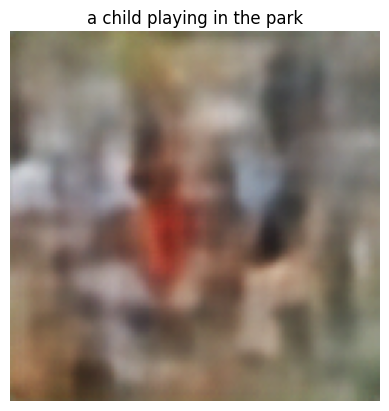

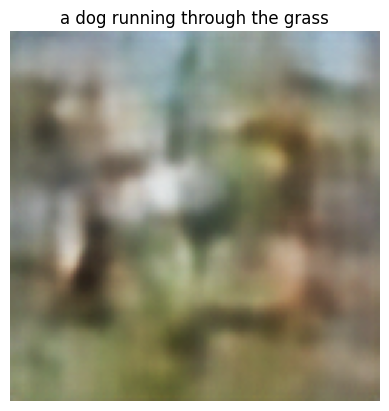

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_image_from_prompt(prompt: str, save_path=None):
    # Embed prompt
    tokens = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_embedding = bert_model(**tokens).last_hidden_state[:, 0, :]  # CLS token
        text_condition = model.condition_layer(text_embedding)

        # Sample latent z ~ N(0, I)
        z = torch.randn(1, config.latent_dim).to(device)

        # Generate image
        with torch.no_grad():
            gen_img = model.decode(z, text_condition)

        # Convert to PIL
        image_tensor = gen_img[0].cpu()
        image = ToPILImage()(image_tensor)

        # Save or show
        if save_path:
            image.save(save_path)
            print(f"Image saved to: {save_path}")
        else:
            plt.imshow(image)
            plt.axis('off')
            plt.title(prompt)
            plt.show()

# 🔥 Example usage:
generate_image_from_prompt("a child playing in the park")
generate_image_from_prompt("a dog running through the grass")


## 10. INFERENCE/SAMPLING

In [ ]:
@torch.no_grad()
def sample(unet, vae, text_encoder, tokenizer, diffusion, prompt, num_steps=50):
    """Generate image from text prompt"""
    unet.eval()
    vae.eval()

    # Encode text
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=config.max_text_length,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    text_embeddings = text_encoder(text_inputs.input_ids,
                                  attention_mask=text_inputs.attention_mask).last_hidden_state

    # Start with random noise
    latents = torch.randn(1, config.in_channels, config.latent_size, config.latent_size).to(device)

    # Sampling loop (simplified DDPM)
    timesteps = torch.linspace(config.noise_schedule_steps-1, 0, num_steps).long().to(device)

    for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
        t_batch = t.unsqueeze(0)

        # Predict noise
        predicted_noise = unet(latents, t_batch, text_embeddings)

        # Simple sampling step (this is simplified - real DDPM has more complex sampling)
        alpha_t = diffusion.alphas_cumprod[t]
        alpha_t_prev = diffusion.alphas_cumprod[max(0, t-1)] if t > 0 else torch.tensor(1.0)

        beta_t = 1 - alpha_t / alpha_t_prev if t > 0 else 0

        # Compute x_{t-1}
        if t > 0:
            noise = torch.randn_like(latents)
        else:
            noise = torch.zeros_like(latents)

        # Simplified denoising step
        latents = (latents - beta_t * predicted_noise / torch.sqrt(1 - alpha_t)) / torch.sqrt(1 - beta_t)
        latents = latents + torch.sqrt(beta_t) * noise

    # Decode latents to image
    image = vae.decode(latents)
    image = (image + 1) / 2  # Convert from [-1, 1] to [0, 1]
    image = torch.clamp(image, 0, 1)

    return image

@torch.no_grad()
def generate_samples(unet, vae, text_encoder, tokenizer, diffusion, epoch):
    """Generate sample images during training"""
    sample_prompts = [
        "A red cat sitting on a chair",
        "A blue car driving on a road",
        "A green tree in a park",
        "A yellow flower in a garden"
    ]

    print(f"\nGenerating samples for epoch {epoch}...")

    for i, prompt in enumerate(sample_prompts):
        try:
            image = sample(unet, vae, text_encoder, tokenizer, diffusion, prompt, num_steps=20)

            # Convert to PIL and save
            image_pil = transforms.ToPILImage()(image.squeeze(0).cpu())
            sample_path = os.path.join(config.output_dir, f'sample_epoch_{epoch}_prompt_{i}.png')
            image_pil.save(sample_path)
            print(f"Saved sample: {sample_path}")

        except Exception as e:
            print(f"Error generating sample for prompt '{prompt}': {e}")

    print("Sample generation completed.\n")

## 11. UTILITY FUNCTIONS FOR INFERENCE

In [ ]:
def load_trained_model(checkpoint_path):
    """Load a trained model from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Initialize models
    unet = UNetModel(checkpoint['config']).to(device)
    vae = SimpleVAE().to(device)

    # Load state dicts
    unet.load_state_dict(checkpoint['unet_state_dict'])
    vae.load_state_dict(checkpoint['vae_state_dict'])

    # Load text encoder
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    # Initialize diffusion
    betas = make_beta_schedule("linear", checkpoint['config'].noise_schedule_steps,
                              checkpoint['config'].beta_start, checkpoint['config'].beta_end)
    diffusion = GaussianDiffusion(betas.to(device))

    return unet, vae, text_encoder, tokenizer, diffusion

def generate_image_from_text(checkpoint_path, prompt, output_path, num_steps=50):
    """Generate image from text using trained model"""
    unet, vae, text_encoder, tokenizer, diffusion = load_trained_model(checkpoint_path)

    image = sample(unet, vae, text_encoder, tokenizer, diffusion, prompt, num_steps)

    # Save image
    image_pil = transforms.ToPILImage()(image.squeeze(0).cpu())
    image_pil.save(output_path)
    print(f"Generated image saved: {output_path}")

    return image_pil


## 12. MAIN TRAINING EXECUTION

In [ ]:
def main():
    """Main function to start training"""
    print("=" * 60)
    print("STABLE DIFFUSION TRAINING FROM SCRATCH")
    print("=" * 60)

    # Print configuration
    print(f"Configuration:")
    print(f"- Image size: {config.image_size}x{config.image_size}")
    print(f"- Batch size: {config.batch_size}")
    print(f"- Learning rate: {config.learning_rate}")
    print(f"- Number of epochs: {config.num_epochs}")
    print(f"- Noise schedule steps: {config.noise_schedule_steps}")
    print(f"- Output directory: {config.output_dir}")
    print(f"- Dataset path: {config.dataset_path}")
    print("=" * 60)

    # Check GPU availability
    if torch.cuda.is_available():
        print(f"GPU Available: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        print("WARNING: No GPU available. Training will be very slow on CPU.")

    print("=" * 60)

    try:
        # Start training
        train_stable_diffusion()

        print("\n" + "=" * 60)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print("=" * 60)

        # Example inference
        print("\nTesting inference with trained model...")
        final_model_path = os.path.join(config.output_dir, 'final_model.pth')
        if os.path.exists(final_model_path):
            test_prompt = "A beautiful sunset over mountains"
            output_image_path = os.path.join(config.output_dir, 'test_generation.png')
            generate_image_from_text(final_model_path, test_prompt, output_image_path)

    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()

## 13. ADDITIONAL UTILITIES

In [ ]:
def visualize_training_progress(output_dir):
    """Visualize training samples"""
    import glob

    sample_files = glob.glob(os.path.join(output_dir, 'sample_*.png'))
    sample_files.sort()

    if len(sample_files) == 0:
        print("No sample images found.")
        return

    # Display some sample images
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, sample_file in enumerate(sample_files[:8]):
        img = Image.open(sample_file)
        axes[i].imshow(img)
        axes[i].set_title(os.path.basename(sample_file))
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(len(sample_files), 8):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_progress.png'), dpi=150, bbox_inches='tight')
    plt.show()

def analyze_model_parameters():
    """Analyze model complexity"""
    unet = UNetModel(config)
    vae = SimpleVAE()

    unet_params = sum(p.numel() for p in unet.parameters())
    vae_params = sum(p.numel() for p in vae.parameters())

    print(f"Model Parameter Count:")
    print(f"- UNet: {unet_params:,} parameters ({unet_params/1e6:.1f}M)")
    print(f"- VAE: {vae_params:,} parameters ({vae_params/1e6:.1f}M)")
    print(f"- Total: {unet_params + vae_params:,} parameters ({(unet_params + vae_params)/1e6:.1f}M)")

## 14. EXECUTION

In [ ]:
if __name__ == "__main__":
    # Analyze model first
    print("Analyzing model complexity...")
    analyze_model_parameters()
    print("\n")

    # Start main training
    main()

    # Visualize results if training completed
    if os.path.exists(config.output_dir):
        print("\nVisualizing training progress...")
        visualize_training_progress(config.output_dir)

Analyzing model complexity...
Model Parameter Count:
- UNet: 642,164,164 parameters (642.2M)
- VAE: 3,706,123 parameters (3.7M)
- Total: 645,870,287 parameters (645.9M)


STABLE DIFFUSION TRAINING FROM SCRATCH
Configuration:
- Image size: 512x512
- Batch size: 4
- Learning rate: 0.0001
- Number of epochs: 100
- Noise schedule steps: 1000
- Output directory: /content/stable_diffusion_output
- Dataset path: /content/dataset
GPU Available: Tesla T4
GPU Memory: 15.8 GB
Initializing Stable Diffusion Training...
Loading models...
Loading dataset...
Starting training with 50000 samples...
Device: cuda
Batch size: 4
Learning rate: 0.0001


Epoch 1/100:   0%|          | 0/12500 [00:00<?, ?it/s]


Error during training: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA_gather)

Visualizing training progress...
No sample images found.



Traceback (most recent call last):
  File "<ipython-input-29-6abc7b315024>", line 29, in main
    train_stable_diffusion()
  File "<ipython-input-26-babb8a4e2320>", line 181, in train_stable_diffusion
    loss = diffusion.p_losses(unet, latents, timesteps, text_embeddings)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-8-820fd4c91648>", line 32, in p_losses
    x_noisy = self.q_sample(x_start, t, noise)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-8-820fd4c91648>", line 22, in q_sample
    sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-3-fc11d441e9dd>", line 17, in extract
    out = a.gather(-1, t.cpu())
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument ind